In [ ]:
# import torch
# import torchvision
# from torch import nn
# from torch.utils.data import DataLoader
# from matplotlib import pyplot as plt
# from torchvision import datasets
# from torchvision import transforms
# import numpy
# import cv2

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Using device: {device}')


In [ ]:
# # dataset = torchvision.datasets.MNIST(root="../data", train=True, download=True, transform=torchvision.transforms.ToTensor())

# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     ])
# dataset = datasets.ImageFolder(root="SkinData/data", transform=transform)
# # data_loader = torch.utils.data.DataLoader(dataset)
# # おっと、4が混ざりました。1か8か、あるいは4です。
# # 好きな数字に変えても良いでしょう。
# target_values = [0,1]

# target_images = []
# for data in dataset:
#     if data[1] in target_values:
#         target_images.append(data)

# train_dataloader = DataLoader(target_images, batch_size=8, shuffle=True)

In [ ]:
# def corrupt(x, amount):
#   """
#     x : 入力する画像(複数), x.shape = torch.Size([batch_size, 1, 28, 28])
#     amount : 各画像にどれだけノイズを入れるかの比率を入れたndarray, 0->そのまま, 1->完全にノイズ
#   """
#   noise = torch.rand_like(x)
#   amount = amount.view(-1, 1, 1, 1) 
#   return x*(1-amount) + noise*amount 


In [ ]:
# batch_size = 128
# train_dataloader = DataLoader(target_images, batch_size=batch_size, shuffle=True)

# max_epochs = 5

# net = BasicUNet()
# net.to(device)

# loss_func = nn.MSELoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 

# history = []
# for epoch in range(max_epochs):
#     for x, y in train_dataloader:
#         x = x.to(device)
#         # どれくらいノイズを入れるかは乱数で決める
#         noise_amount = torch.rand(x.shape[0]).to(device)
#         noisy_x = corrupt(x, noise_amount)

#         pred = net(noisy_x)
#         loss = loss_func(pred, x)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         history.append(loss.item())

#     avg_loss = sum(history[-len(train_dataloader):])/len(train_dataloader)
#     print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# plt.plot(history)
# plt.ylim(0, 0.1)


In [ ]:
# n_steps = 5
# x = torch.rand(8, 1, 28, 28).to(device)
# step_history = [x.detach().cpu()]
# pred_output_history = []

# for i in range(n_steps):
#     with torch.no_grad():
#         pred = net(x)
#     pred_output_history.append(pred.detach().cpu())

#     mix_factor = 1/(n_steps - i)
#     x = x*(1-mix_factor) + pred*mix_factor
#     step_history.append(x.detach().cpu())

# _, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
# axs[0,0].set_title('x (model input)')
# axs[0,1].set_title('model prediction')
# for i in range(n_steps):
#     axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
#     axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')


In [ ]:
# n_steps = 40
# x = torch.rand(64, 1, 28, 28).to(device)

# for i in range(n_steps):
#   with torch.no_grad():
#     pred = net(x)
#   mix_factor = 1/(n_steps - i)
#   x = x*(1-mix_factor) + pred*mix_factor

# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

In [86]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import os

class RGBADataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGBA")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = RGBADataset(root="SkinData/data/alex_alpha", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = 64 * 64 * 4  # 64x64のRGBA画像
model = DiffusionModel(input_dim=input_dim, hidden_dim=100, output_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
for epoch in range(num_epochs):
    for data in dataloader:
        images = data
        images = images.view(images.size(0), -1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f"\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item()}", end="")

generated_images = model(torch.randn(1, input_dim))
generated_images = generated_images.view(4, 64, 64).detach().numpy()

image_array_scaled = (np.transpose(generated_images, (1, 2, 0)) * 255).astype(np.uint8)
img = cv2.cvtColor(image_array_scaled, cv2.COLOR_RGB2BGRA)
dir_path = "Created_Skin/"
files = os.listdir(dir_path)
cv2.imwrite(f'{dir_path}ai_{len(files)+1}.png', img)

plt.imshow(np.transpose(generated_images[:3], (1, 2, 0)))
plt.axis('off')
plt.show()


Epoch 83/1000, Loss: 0.0023104068823158745

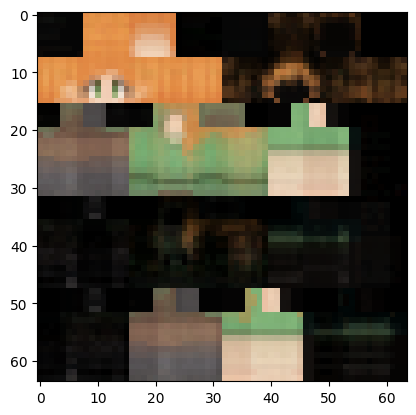

In [98]:
import os
import cv2

h, w = img.shape[:2]
for i in range(h):
    for j in range(w):
        b, g, r, a = img[i, j]
        img[i,j] = [b,g,r,min(255,a+50)]
        # if (int(b)+int(g)+int(r) <= 190) and ((32<= j and i <= 15) or (32 <= i <= 47) or (j <= 15 and 48 <= i) or (46 <= j and 48 <= i)):
            # img[i,j] = [0,0,0,0]
        # elif ((32<= j and i <= 15) or (32 <= i <= 47) or (j <= 15 and 48 <= i) or (46 <= j and 48 <= i)):
            # num = 20
            # img[i,j] = [min(255,b+(num+b//2)), min(255,g+(num+g//2)), min(255,r+(num+r//2)), 255]
            # _b, _g, _r, _a = img[i, j]
            # if int(_b)+int(_g)+int(r) <= 250:
            #     img[i,j] = [0,0,0,0]

dir_path = "Created_Skin/"
files = os.listdir(dir_path)
cv2.imwrite(f'{dir_path}ai_{len(files)+1}.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
plt.show()

In [46]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [47]:
# dataset = torchvision.datasets.MNIST(root="/data", train=True, download=True, transform=torchvision.transforms.ToTensor())

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="SkinData/data", transform=transform)
dataloader = DataLoader(dataset, shuffle=True)

# おっと、4が混ざりました。1か8か、あるいは4です。
# 好きな数字に変えても良いでしょう。
# target_values = [1, 8, 4]

# target_images = []
# for data in dataset:
#     if data[1] in target_values:
#         target_images.append(data)

# train_dataloader = DataLoader(target_images, batch_size=8, shuffle=True)


In [49]:
def corrupt(x, amount):
    """
        x : 入力する画像(複数), x.shape = torch.Size([batch_size, 1, 28, 28])
        amount : 各画像にどれだけノイズを入れるかの比率を入れたndarray, 0->そのまま, 1->完全にノイズ
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) 
    return x*(1-amount) + noise*amount 

# # ノイズが加わる様子を可視化
# amount = torch.linspace(0, 1, x.shape[0])
# noised_x = corrupt(x, amount)

# _, axs = plt.subplots(2, 1, figsize=(12, 5))
# axs[0].set_title('Input data')
# axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
# axs[1].set_title('Corrupted data (-- amount increases -->)')
# axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');


In [70]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down_layer1 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
        self.down_layer2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.down_layer3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        
        self.up_layer1 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.up_layer2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.up_layer3 = nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
        
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = lambda x: F.interpolate(x, scale_factor=2, mode='nearest')

    def forward(self, x):
        x1 = self.act(self.down_layer1(x))
        x2 = self.downscale(x1)
        x2 = self.act(self.down_layer2(x2))
        x3 = self.downscale(x2)
        x3 = self.act(self.down_layer3(x3))

        y = self.act(self.up_layer1(x3))
        y = self.upscale(y) + x2
        y = self.act(self.up_layer2(y))
        y = self.upscale(y) + x1
        y = self.act(self.up_layer3(y))
        return y


Finished epoch 49. Average loss for this epoch: 0.020822

(0.0, 0.1)

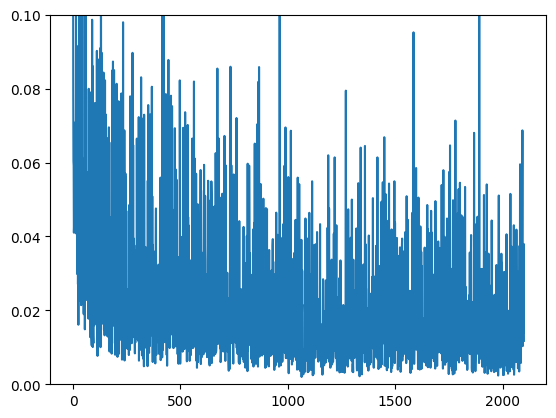

In [68]:
batch_size = 128
dataloader = DataLoader(dataset, shuffle=True)

max_epochs = 50

net = BasicUNet()
net.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 

history = []
for epoch in range(max_epochs):
    for x, y in dataloader:
        x = x.to(device)
        # どれくらいノイズを入れるかは乱数で決める
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)
        loss = loss_func(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history.append(loss.item())

    avg_loss = sum(history[-len(dataloader):])/len(dataloader)
    print(f'\rFinished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}',end="")

plt.plot(history)
plt.ylim(0, 0.1)


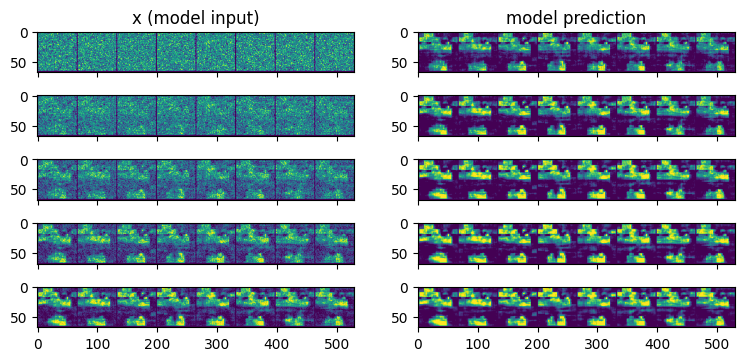

In [72]:
n_steps = 5
x = torch.rand(8, 3, 64, 64).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())

    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor
    step_history.append(x.detach().cpu())

_, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1))
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1))


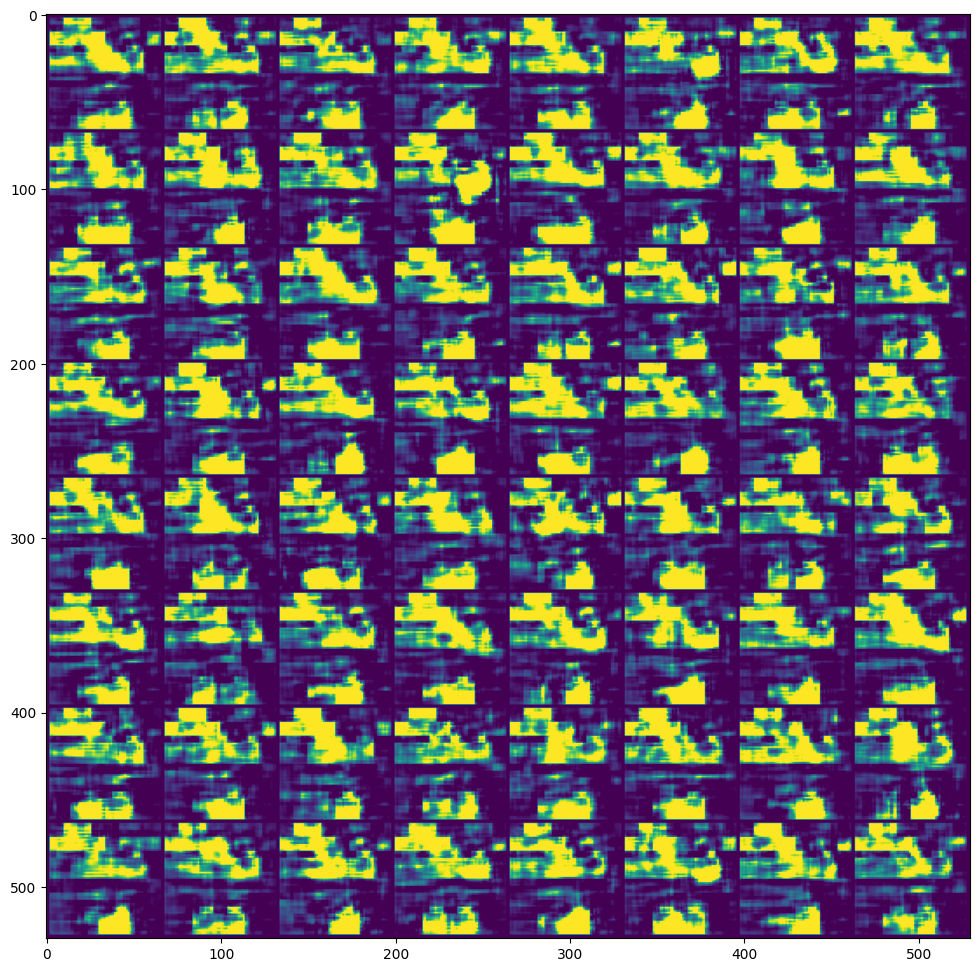

In [74]:
n_steps = 140
x = torch.rand(64, 3, 64, 64).to(device)

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1))
